02.12.2019 <br>
Selected features (see Google doc)

In [1]:
                                                                                                                                                                                                        import pandas as pd
                                                                                                                                                                                                        import numpy as np
                                                                                                                                                                                                        import matplotlib.pyplot as plt
                                                                                                                                                                                                        import pandas as pd
                                                                                                                                                                                                        import psycopg2
                                                                                                                                                                                                        import sys
                                                                                                                                                                                                        sys.path.insert(1, "C:/sers/jaege/PycharmProjects/labour-katharina")
                                                                                                                                                                                                        from labor_katharina import contraction_features_02
                                                                                                                                                                                                        from labor_katharina import regression
                                                                                                                                                                                                        from labor_katharina import permutation, labels
                                                                                                                                                                                                        import datetime
                                                                                                                                                                                                        import seaborn as sns
                                                                                                                                                                                                        from sklearn.feature_selection import SelectKBest, chi2, f_regression

In [2]:
# load data
#features = pd.read_pickle('./data/features/2020-01-09_16-31-22/noEdge/features.pkl')
#load data between week 30 and 40
#features = pd.read_pickle('./data/features/2020-01-13_13-45-33/noEdge/features.pkl')

#classification features
features = pd.read_pickle('./data/features/2020-01-09_16-31-22/noEdge/features.pkl')
recordings = pd.read_pickle('./data/features/2020-01-09_16-31-22/recordings.pkl')


In [3]:
#add labor label
recordings['label'] = [1 if (bb - ca).days == 0 else 0 for bb, ca in zip(recordings['baby_birthdate'], recordings['created_at'].dt.date)]
recordings['label'] = [2 if (bb - ca).days == 1 else l for bb, ca,l in zip(recordings['baby_birthdate'], recordings['created_at'].dt.date, recordings['label'])]
recordings = recordings[recordings['label'] != 2]
features['labor'] = [recordings.loc[a, 'label'] for a in features['session_id']]
recordings.drop(columns=['label']);

#add TTD labels
#_, features = labels.TTD.create(features,2)

In [4]:
feature_names = ['count', 'duration_median', 'duration_iqr', 'duration_rmssd',
                                     'auc_median', 'auc_iqr', 'auc_rmssd', 'variability', 'regularity_0', 'regularity_1',
                                     'regularity_2' , 'regularity_e', 'rmssd', 'gestational_age']

In [5]:
# cast to float
for feature in feature_names:
    features[feature] = pd.to_numeric(features[feature],errors='coerce')


## Distribution

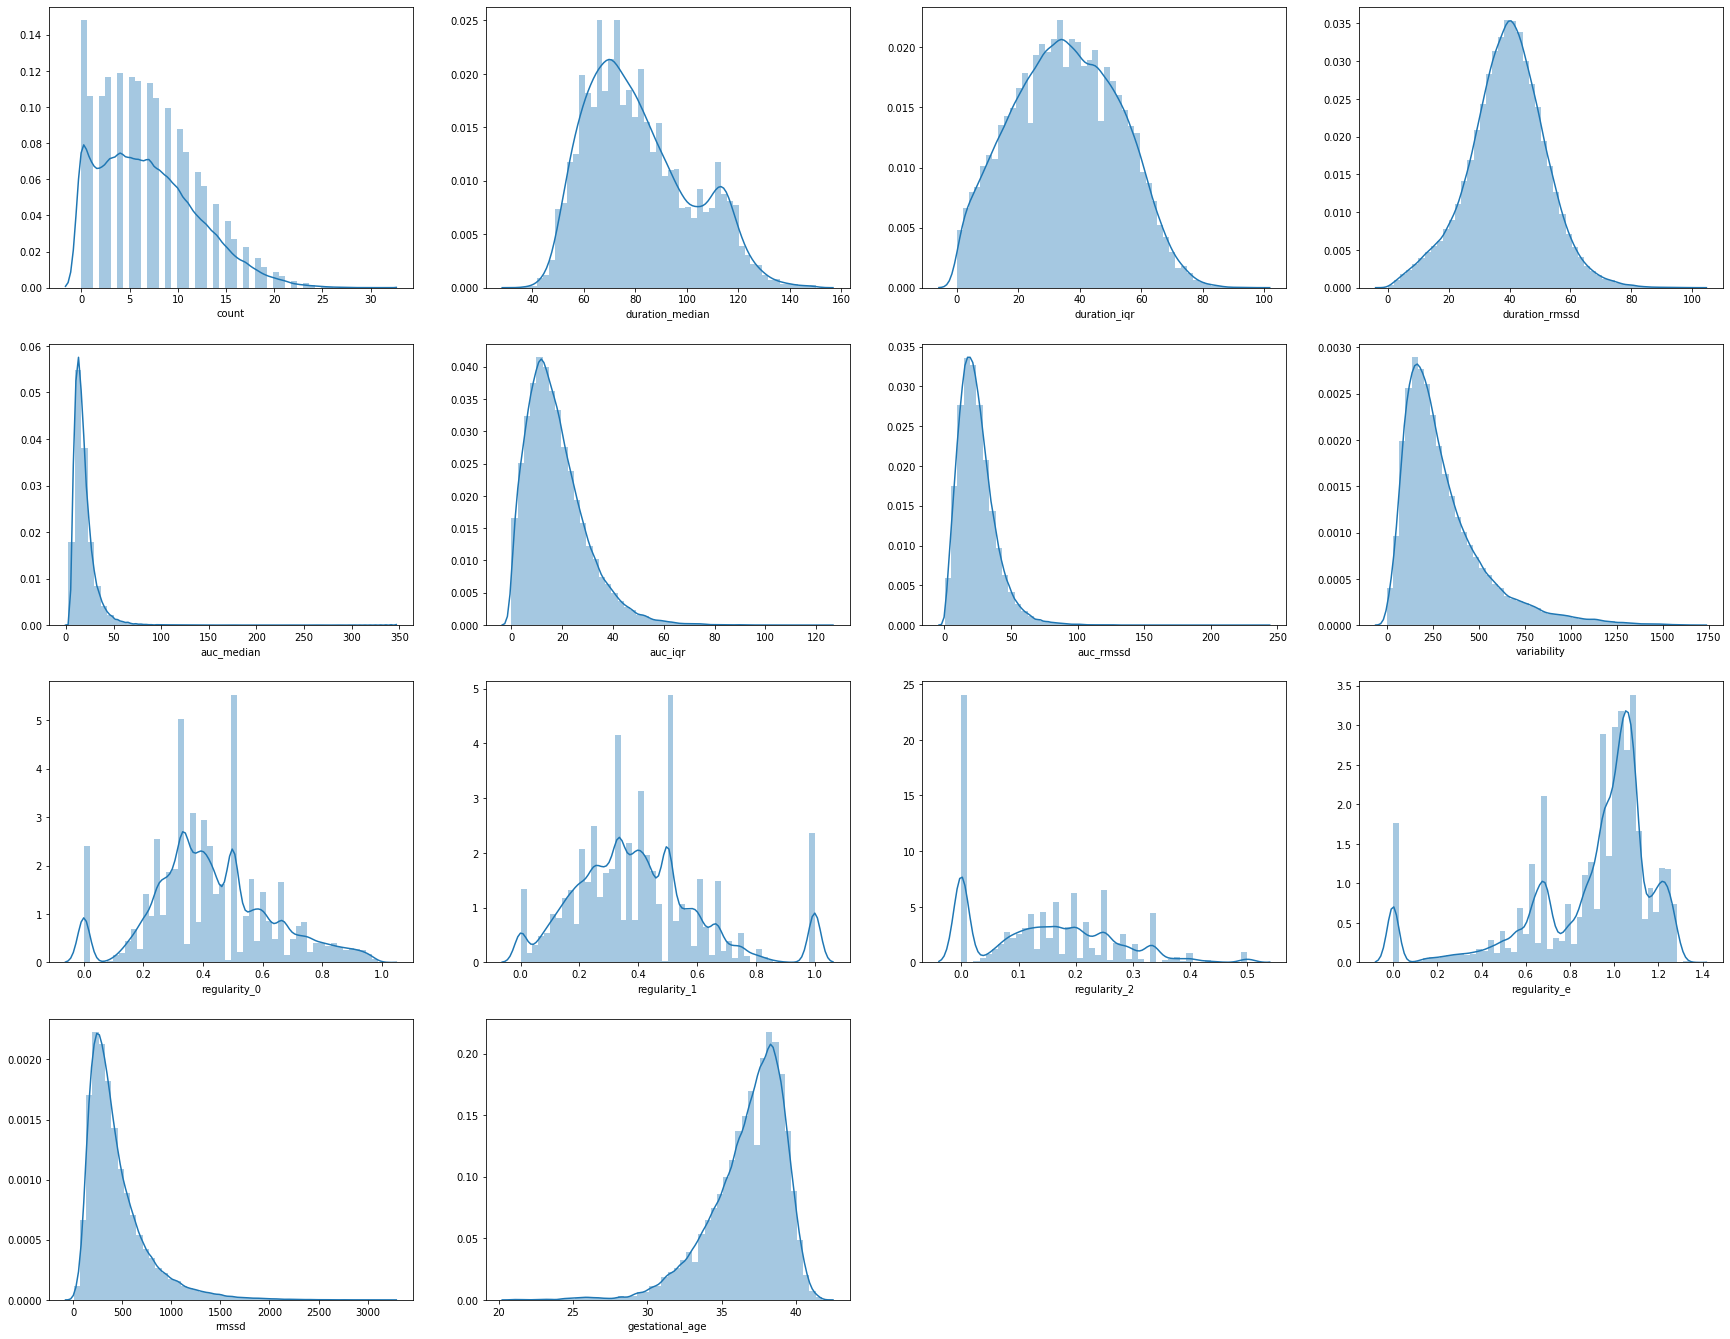

In [6]:
fig = plt.figure(figsize= (30,30))
fig.suptitle('', fontsize=30)

for i, feature in enumerate(feature_names):
    ax = plt.subplot(5,4,i+1)
    feature_noNan = features[~np.isnan(features[feature])][feature]
    sns.distplot(feature_noNan, hist=True, kde=True)

In [7]:
feature = 'variability'
fig = plt.figure(figsize=(7,7))
f_nl = features[features['labor']==0][feature]
feature_noNan_nl = f_nl[~np.isnan(f_nl)]
sns.distplot(feature_noNan_nl, hist=True, kde=True, label='non-labor')

f_l = features[features['labor']==1][feature]
feature_noNan_l = f_l[~np.isnan(f_l)]
sns.distplot(feature_noNan_l, hist=True, kde=True, label='labor')
plt.legend()

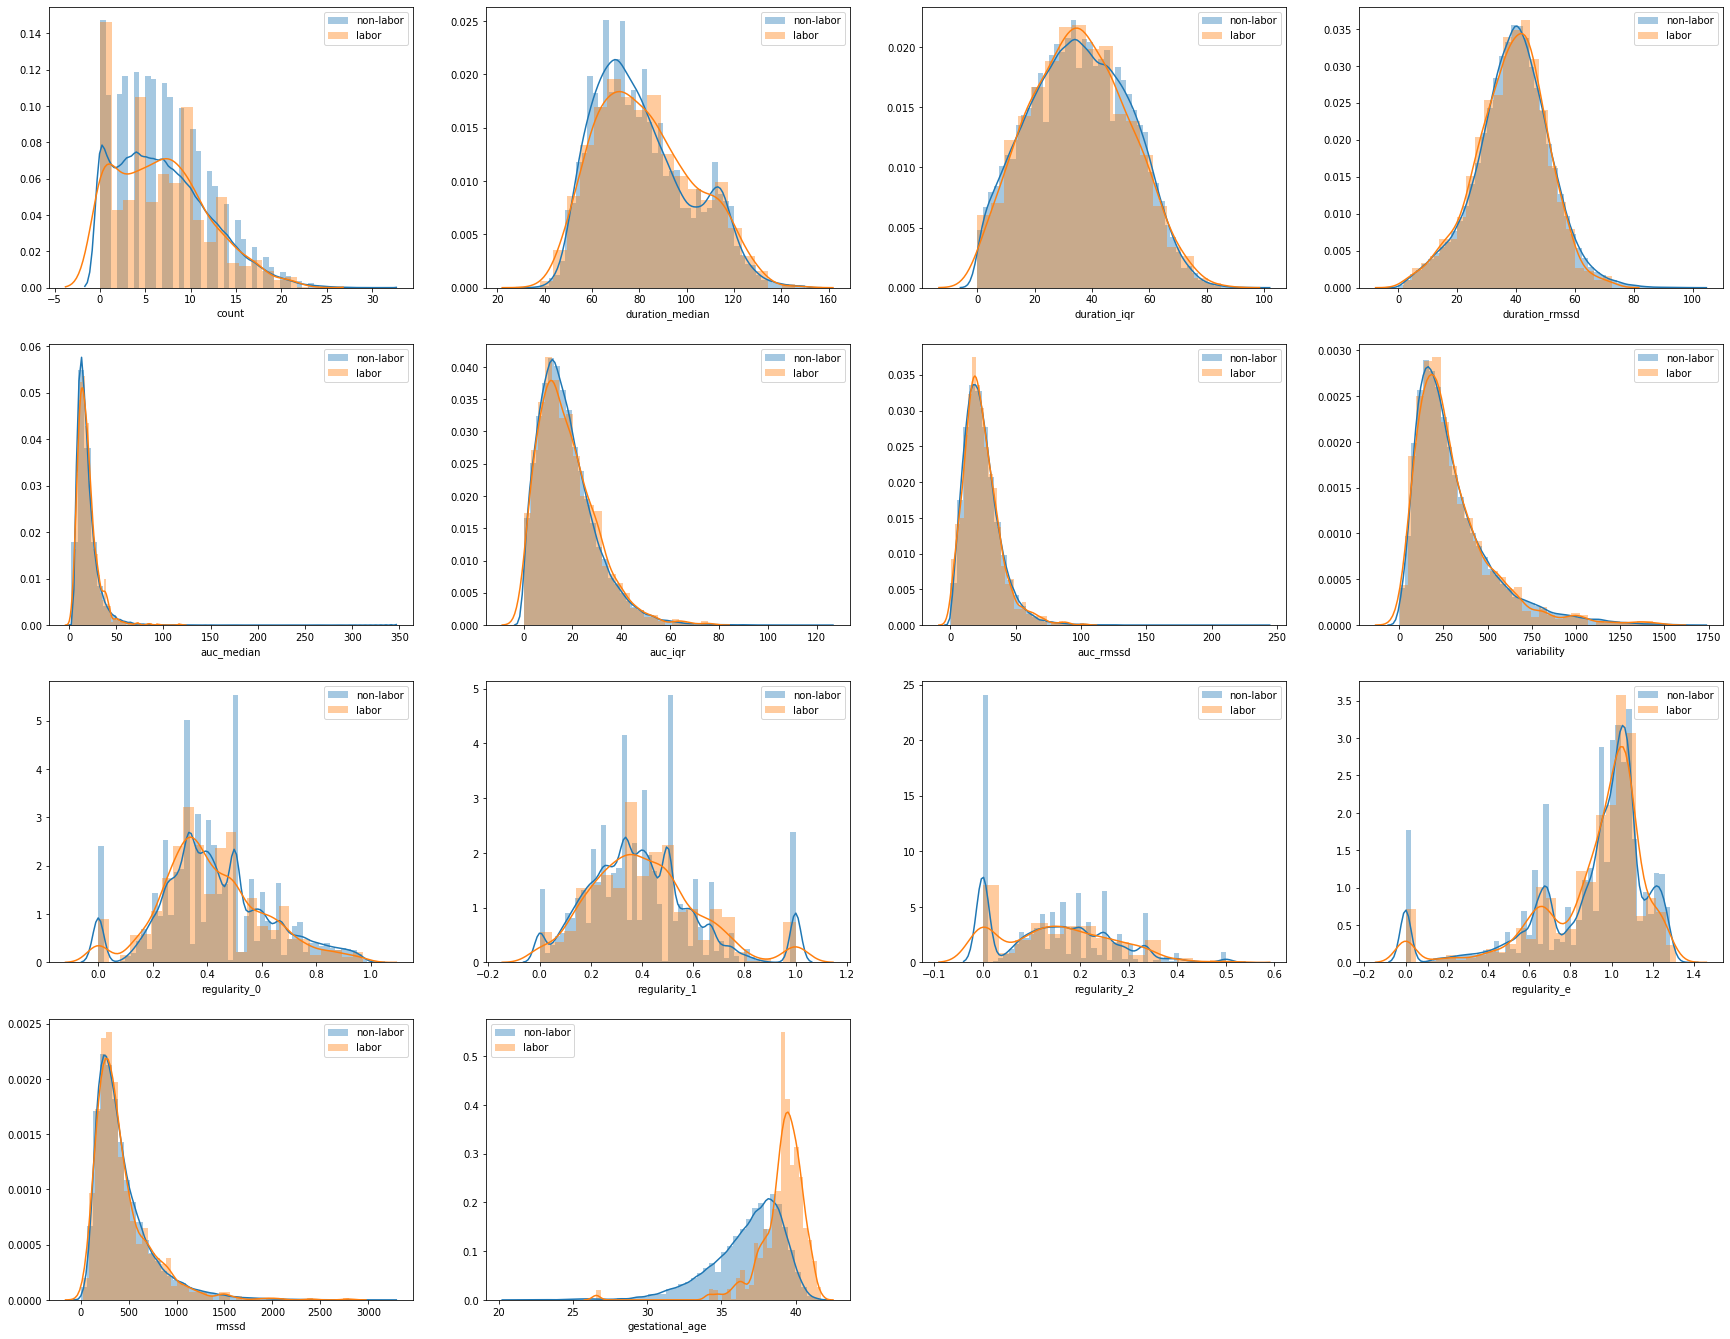

In [8]:
fig = plt.figure(figsize= (30,30))
fig.suptitle('', fontsize=30)

for i, feature in enumerate(feature_names):
    ax = plt.subplot(5,4,i+1)
    f_nl = features[features['labor']==0][feature]
    feature_noNan_nl = f_nl[~np.isnan(f_nl)]
    sns.distplot(feature_noNan_nl, hist=True, kde=True, label='non-labor')
    
    f_l = features[features['labor']==1][feature]
    feature_noNan_l = f_l[~np.isnan(f_l)]
    sns.distplot(feature_noNan_l, hist=True, kde=True, label='labor')
    plt.legend()
    

## Pairplot

D:\Programs\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
D:\Programs\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
D:\Programs\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
D:\Programs\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


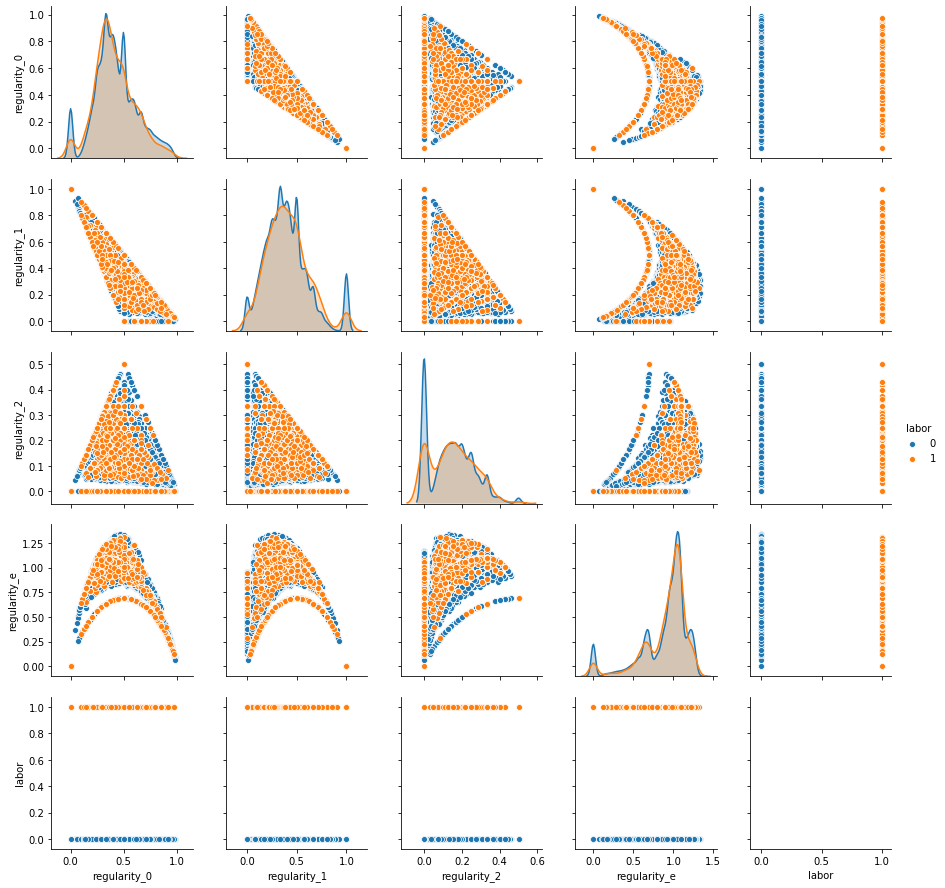

In [9]:
reg_feat_names = ['regularity_0', 'regularity_1', 'regularity_2', 'regularity_e', 'labor']
reg_features = features[reg_feat_names]
sns.pairplot(reg_features, hue='labor', dropna=True)

## Temporal evolvement of features

### Median in 1 hour segments

D:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


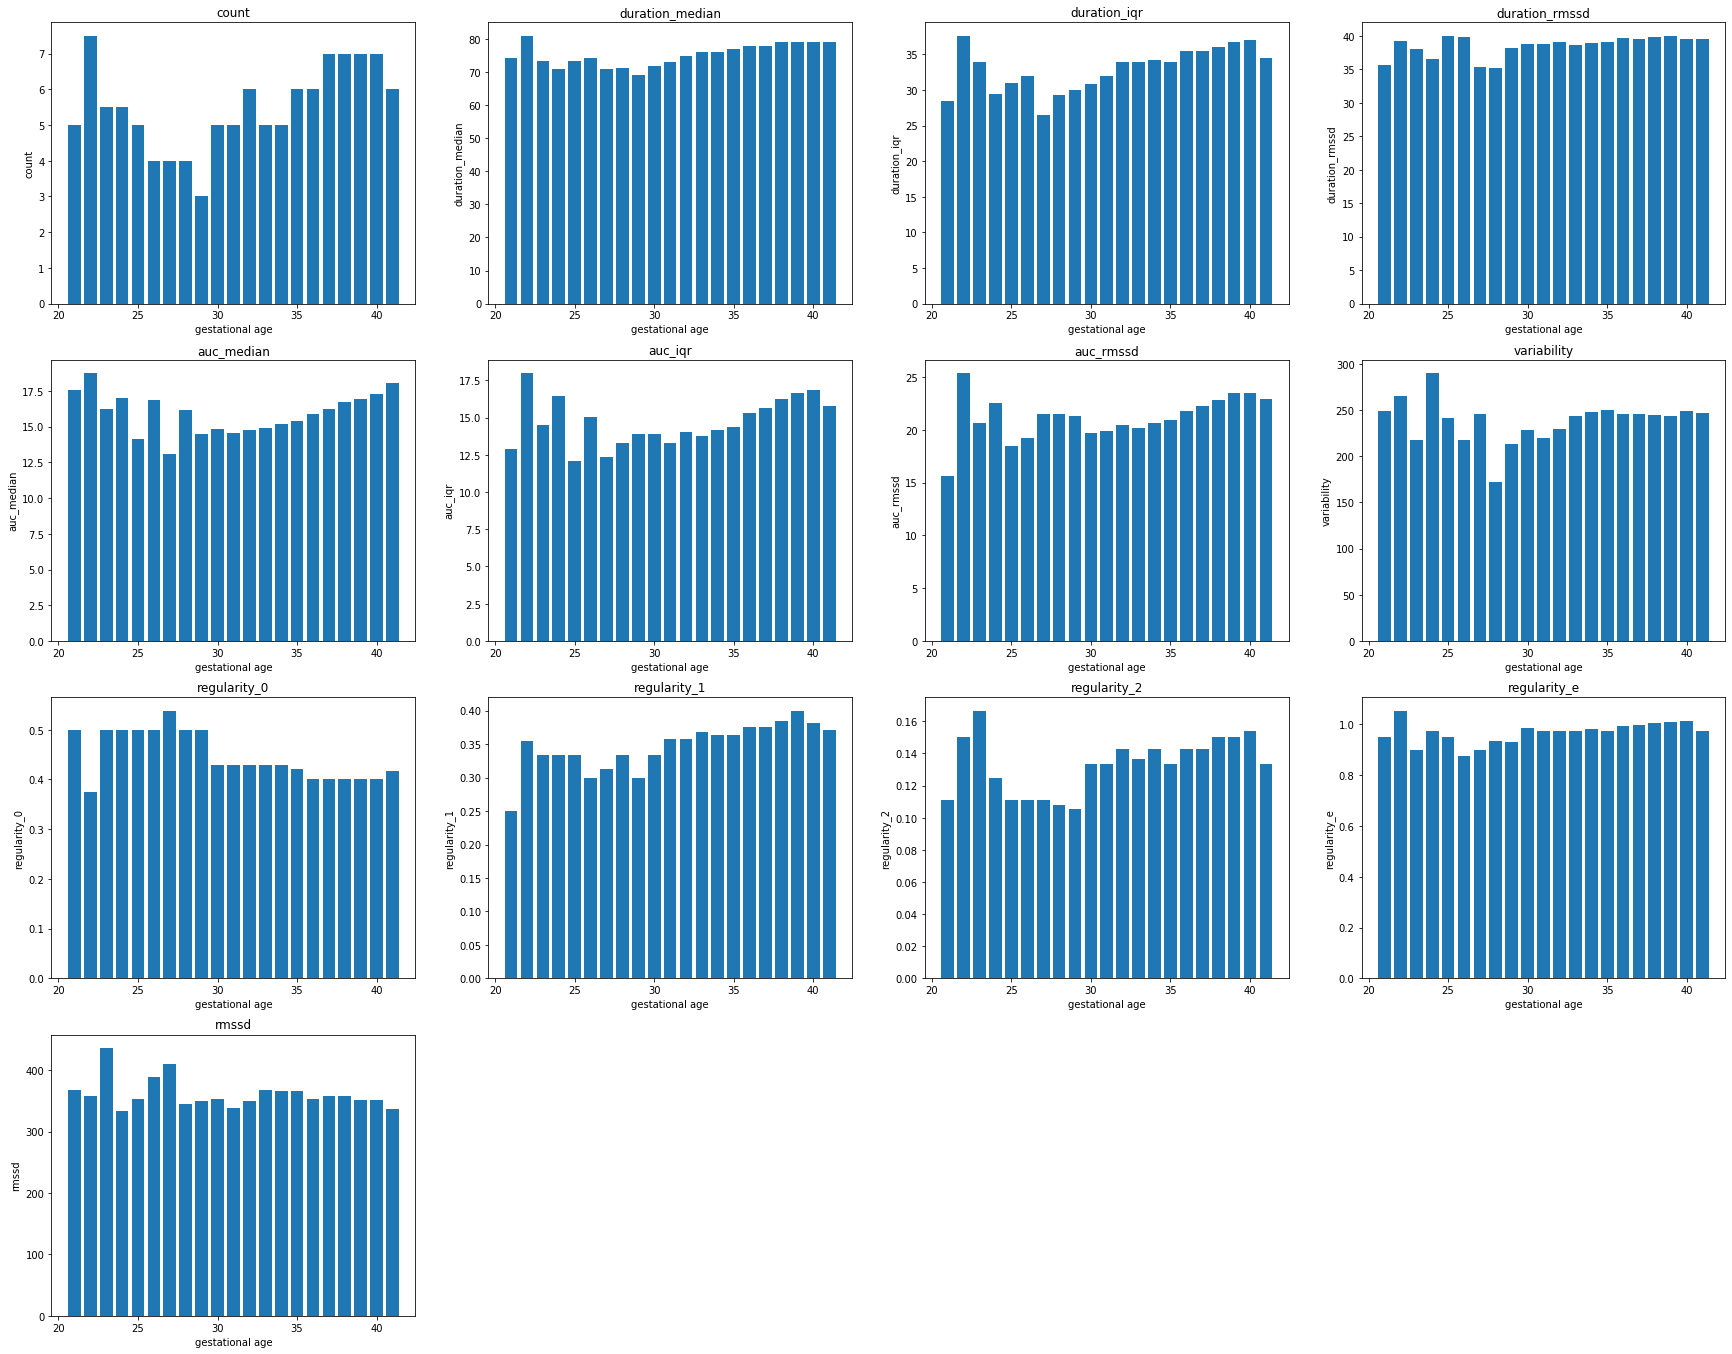

In [10]:
feature_names = ['count', 'duration_median', 'duration_iqr', 'duration_rmssd',
                                     'auc_median', 'auc_iqr', 'auc_rmssd', 'variability', 'regularity_0', 'regularity_1',
                                     'regularity_2' , 'regularity_e', 'rmssd']
fig = plt.figure(figsize= (30,30))
fig.suptitle('', fontsize=30)

for i, f in enumerate(feature_names):
    ax = plt.subplot(5,4,i+1)
    f_tmp = features[[f, 'gestational_age']]
    f_tmp['gestational_age'] = f_tmp['gestational_age'].apply(np.floor)  
    bar = f_tmp.groupby('gestational_age').median()
    plt.bar(bar.index.values, bar[f])
    plt.ylabel(f)
    plt.xlabel('gestational age')
    plt.title(f)

D:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'auc_iqr')

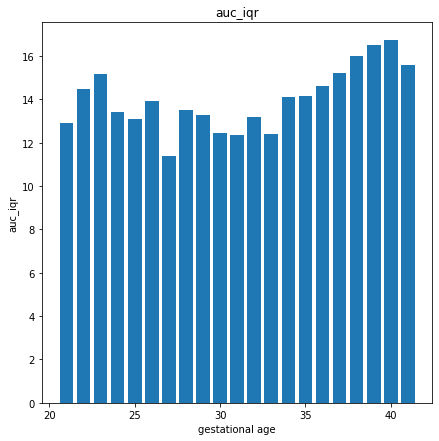

In [11]:
f = 'auc_iqr'
fig = plt.figure(figsize=(7,7))
f_tmp = features[[f, 'gestational_age', 'user_id']]
f_tmp['gestational_age'] = f_tmp['gestational_age'].apply(np.floor) 
tmp = f_tmp.groupby(['gestational_age', 'user_id']).median()
bar = tmp.groupby('gestational_age').median()
plt.bar(bar.index.values, bar[f])
plt.ylabel(f)
plt.xlabel('gestational age')
plt.title(f)

### Median subject normalized

D:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


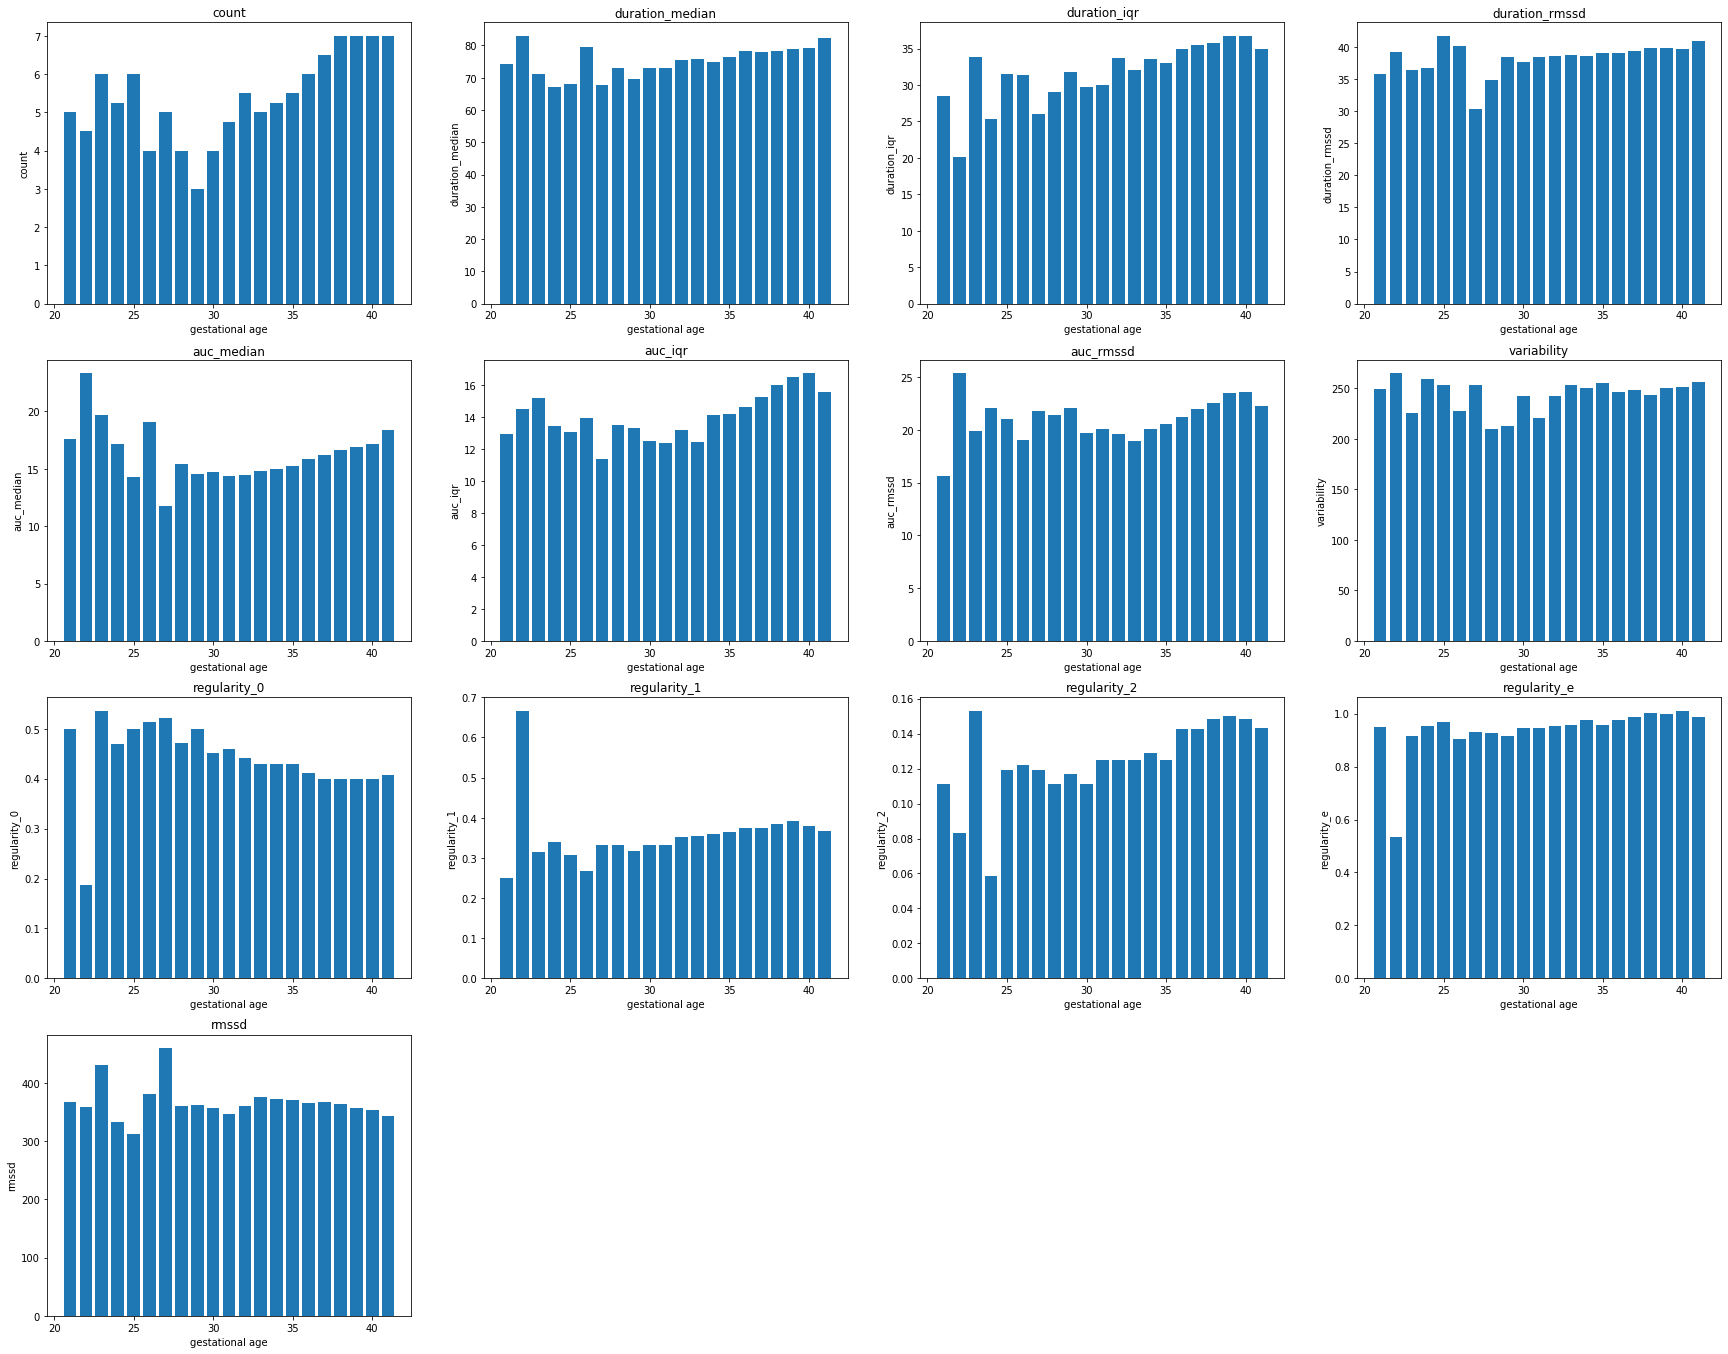

In [12]:
feature_names = ['count', 'duration_median', 'duration_iqr', 'duration_rmssd',
                                     'auc_median', 'auc_iqr', 'auc_rmssd', 'variability', 'regularity_0', 'regularity_1',
                                     'regularity_2' , 'regularity_e', 'rmssd']
fig = plt.figure(figsize= (30,30))
fig.suptitle('', fontsize=30)

for i, f in enumerate(feature_names):
    ax = plt.subplot(5,4,i+1)
    f_tmp = features[[f, 'gestational_age', 'user_id']]
    f_tmp['gestational_age'] = f_tmp['gestational_age'].apply(np.floor) 
    tmp = f_tmp.groupby(['gestational_age', 'user_id']).median()
    bar = tmp.groupby('gestational_age').median()
    plt.bar(bar.index.values, bar[f])
    plt.ylabel(f)
    plt.xlabel('gestational age')
    plt.title(f)

#### Fit regression to temporal evolution

In [13]:
n_sim = 500000
r = regression.fit(features, feature_names)
r = r.set_index('user_id')
t = permutation.test_features(r, n_sim)
t = t.set_index('feature')
t

KeyboardInterrupt: 

In [ ]:
n_sim = 500000
r = regression.fit(features, feature_names)
r = r.set_index('user_id')
t = permutation.test_features(r, n_sim)
t = t.set_index('feature')
t

In [ ]:
#remove preterms
#check only from week 30

In [ ]:
set(features[features['gestational_age']>=41]['user_id'].values)

In [ ]:
recordings = pd.read_pickle('./data/06/noEdge/train/recordings-06.pkl')

In [ ]:
fig = plt.figure(figsize=(7,7))
f = features['gestational_age'].apply(np.floor)
x, counts = np.unique(f, return_counts=True)
plt.bar(x, counts)
plt.xlabel('Gestational age')
plt.ylabel('Number of features')

In [ ]:
for i in range(len(x)):
    print('Week '+ str(x[i])+ ': '+ str(counts[i]/sum(counts)))

### Plot histograms per subject (to check if cuts are at same time in different features)

In [ ]:
feature_names = ['count', 'duration_iqr', 'auc_iqr','variability', 'regularity_0', 'rmssd']
fig = plt.figure(figsize= (30,30))
fig.suptitle('', fontsize=30)

users_part = features['user_id'].unique()[0:10]
i=0
for u in users_part:
    features_u = features[features['user_id'].isin(users_part)]
    for k, f in enumerate(feature_names):
        print(i)
        ax = plt.subplot(10,6,i+1)
        tmp = features_u[[f, 'gestational_age']]
        f_tmp['gestational_age'] = tmp['gestational_age'].apply(np.floor) 
        #tmp = f_tmp.groupby(['gestational_age', 'user_id']).median()
        bar = tmp.groupby('gestational_age').median()
        plt.bar(bar.index.values, bar[f])
        plt.ylabel(f)
        plt.xlabel('gestational age')
        plt.title(f)
        i=i+1